This notebook allow to constrain the 3D morphology of galaxies identified on a given survey, from their observed projected images

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import linalg

from astropy.io import fits
from astropy.table import Table
from astropy.cosmology import FlatLambdaCDM

from astropy.coordinates import SkyCoord, match_coordinates_sky
from astropy.coordinates import concatenate
from astropy import units as u

from matplotlib.patches import Ellipse
from scipy.spatial.transform import Rotation

import treecorr
import random

import torch
from torch.distributions import Uniform

from sbi.utils import BoxUniform
from sbi.analysis import pairplot
from sbi.inference import NPE, SNPE, simulate_for_sbi, infer
from sbi.utils.user_input_checks import (
    check_sbi_inputs,
    process_prior,
    process_simulator,
    prepare_for_sbi
)

import corner
import seaborn as sns

/opt/homebrew/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Downloading the data for analysis

- Samples of galaxies considered : ELG, LRG, BGS (DESI data) and CMASS galaxies (SDSS data), matched with UNIONS shapes

In [2]:
# CMASS-UNIONS

unions_cmass_table = Table.read('/Users/antonincorinaldi/Documents/stage césure/code/projet_stage/sbi/unions_cmass_cross.fits')

names = [name for name in unions_cmass_table.colnames if len(unions_cmass_table[name].shape) <= 1]
filtered_tbl = unions_cmass_table[names]

unions_cmass_cross = filtered_tbl.to_pandas()
unions_cmass_cross.columns

nb_unions_cmass = len(unions_cmass_cross) ; print(f"Number of CMASS-UNIONS galaxies : {nb_unions_cmass}")

unions_cmass_index = unions_cmass_cross.index
unions_cmass_index=np.array(unions_cmass_index)

Number of CMASS-UNIONS galaxies : 210440


In [3]:
# ELG-UNIONS

unions_elg_table = Table.read('/Users/antonincorinaldi/Documents/stage césure/code/projet_stage/sbi/unions_elg_cross.fits')

names = [name for name in unions_elg_table.colnames if len(unions_elg_table[name].shape) <= 1]
filtered_tbl = unions_elg_table[names]

unions_elg_cross = filtered_tbl.to_pandas()
unions_elg_cross.columns

nb_unions_elg = len(unions_elg_cross) ; print(f"Number of ELG-UNIONS : {nb_unions_elg}")

unions_elg_index = unions_elg_cross.index
unions_elg_index=np.array(unions_elg_index)

Number of ELG-UNIONS : 243544


In [4]:
# LRG-UNIONS

unions_lrg_table = Table.read('/Users/antonincorinaldi/Documents/stage césure/data/unions_desi_lrg_catalogue.fits')

names = [name for name in unions_lrg_table.colnames if len(unions_lrg_table[name].shape) <= 1]
filtered_tbl = unions_lrg_table[names]

unions_lrg_cross = filtered_tbl.to_pandas()
unions_lrg_cross.columns

nb_unions_lrg = len(unions_lrg_cross) ; print(f"Number of LRG-UNIONS : {nb_unions_lrg}")

unions_lrg_index = unions_lrg_cross.index

Number of LRG-UNIONS : 329819


In [5]:
# LRG+ELG-UNIONS

unions_lrg_elg_table = Table.read('/Users/antonincorinaldi/Documents/stage césure/data/unions_desi_lrg+elg_catalogue.fits')

names = [name for name in unions_lrg_elg_table.colnames if len(unions_lrg_elg_table[name].shape) <= 1]
filtered_tbl = unions_lrg_elg_table[names]

unions_lrg_elg_cross = filtered_tbl.to_pandas()
unions_lrg_elg_cross.columns

nb_unions_lrg_elg = len(unions_lrg_elg_cross) ; print(f"Number of LRG+ELG-UNIONS : {nb_unions_lrg_elg}")

unions_lrg_elg_index = unions_lrg_elg_cross.index

Number of LRG+ELG-UNIONS : 595516


In [6]:
# BGS-UNIONS

unions_bgs_table = Table.read('/Users/antonincorinaldi/Documents/stage césure/code/projet_stage/sbi/unions_bgs_cross.fits')

names = [name for name in unions_bgs_table.colnames if len(unions_bgs_table[name].shape) <= 1]
filtered_tbl = unions_bgs_table[names]

unions_bgs_cross = filtered_tbl.to_pandas()
unions_bgs_cross.columns

nb_unions_bgs = len(unions_bgs_cross) ; print(f"Number of BGS-UNIONS : {nb_unions_bgs}")

unions_bgs_index = unions_bgs_cross.index

Number of BGS-UNIONS : 917146


In [7]:
# UNIONS (random galaxies)

num_galaxies_unions = 1_000_000

with fits.open('/Users/antonincorinaldi/Documents/stage césure/data/unions_shapepipe_cut_struc_2024_v1.5.3.fits', memmap=True) as hdul:
    data = hdul[1].data[:num_galaxies_unions]
    selected_columns = ['RA', 'Dec','e1','e2']
    unions = pd.DataFrame({col: data[col].byteswap().newbyteorder() for col in selected_columns})

nb_unions= len(unions) ; print(f"Number of random galaxies of UNIONS : {nb_unions}")

unions_index = unions.index
unions_index=np.array(unions_index)

Number of random galaxies of UNIONS : 1000000


In [8]:
# Somes functions required for further work



# Absolute value of the ellipticity of a galaxy
def abs_e(e1,e2):
    return np.sqrt(e1*e1+e2*e2)

# Minor and major axes of a galaxy
def a_b(e1,e2):
    e = abs_e(e1,e2)
    return 1+e,1-e  

# Complex ellipticity of a galaxy
def e_complex(a,b,r):
    abs_e = (1-(b/a)) / (1+(b/a))
    e1 = abs_e*np.cos(2*r)
    e2 = abs_e*np.sin(2*r)
    return e1, e2

- Absolute ellipticities $\vert e \vert$ of the galaxies for each sample

In [9]:
# P(e) CMASS-UNIONS

e1_values = unions_cmass_cross['e1'][unions_cmass_index]
e2_values = unions_cmass_cross['e2'][unions_cmass_index]


e_cmass = np.vectorize(abs_e)(e1_values, e2_values)

In [10]:
# P(e) ELG-UNIONS

e1_values = unions_elg_cross['e1'][unions_elg_index]
e2_values = unions_elg_cross['e2'][unions_elg_index]


e_elg = np.vectorize(abs_e)(e1_values, e2_values)

In [11]:
# P(e) LRG-UNIONS

e1_values = unions_lrg_cross['e1'][unions_lrg_index]
e2_values = unions_lrg_cross['e2'][unions_lrg_index]


e_lrg = np.vectorize(abs_e)(e1_values, e2_values)

In [12]:
# P(e) LRG+ELG-UNIONS

e1_values = unions_lrg_elg_cross['e1'][unions_lrg_elg_index]
e2_values = unions_lrg_elg_cross['e2'][unions_lrg_elg_index]


e_lrg_elg = np.vectorize(abs_e)(e1_values, e2_values)

In [13]:
# P(e) BGS-UNIONS

e1_values = unions_bgs_cross['e1'][unions_bgs_index]
e2_values = unions_bgs_cross['e2'][unions_bgs_index]


e_bgs = np.vectorize(abs_e)(e1_values, e2_values)

In [14]:
# P(e) UNIONS

e1_values = unions['e1'][unions_index]
e2_values = unions['e2'][unions_index]


e_unions = np.vectorize(abs_e)(e1_values, e2_values)

### Summary statistics $P(\vert e \vert)$

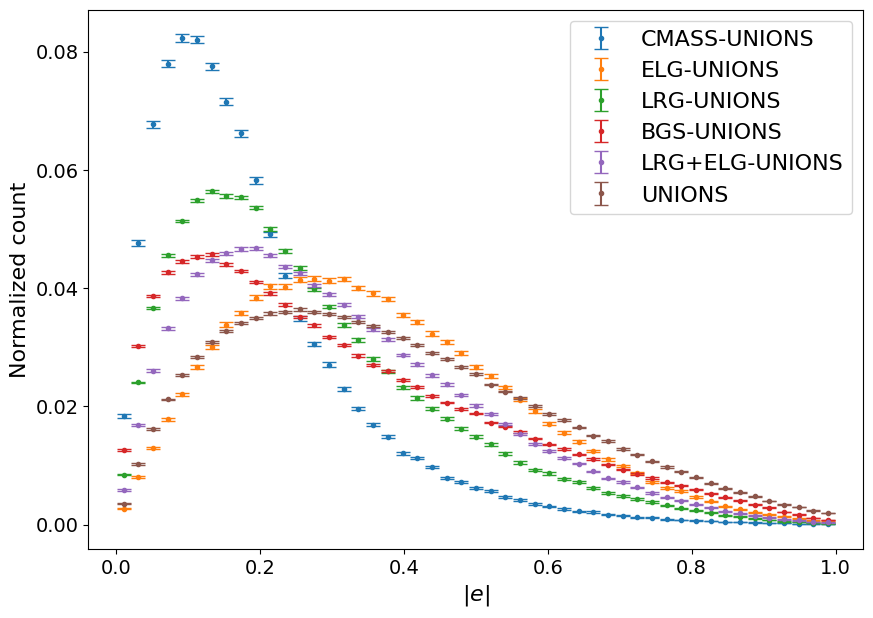

In [15]:
e_bins=np.linspace(0,1,50)
e_cents = (e_bins[1:]+e_bins[:-1])/2.


e_data_counts_cmass,_ = np.histogram(e_cmass, bins = e_bins) 
e_counts_data = [e_data_counts_cmass]
e_counts_data_cmass=np.array(e_counts_data)
x_obs_cmass = e_counts_data_cmass/nb_unions_cmass


e_data_counts_elg,_ = np.histogram(e_elg, bins = e_bins) 
e_counts_data = [e_data_counts_elg]
e_counts_data_elg=np.array(e_counts_data)
x_obs_elg = e_counts_data_elg/nb_unions_elg


e_data_counts_lrg,_ = np.histogram(e_lrg, bins = e_bins) 
e_counts_data = [e_data_counts_lrg]
e_counts_data_lrg=np.array(e_counts_data)
x_obs_lrg = e_counts_data_lrg/nb_unions_lrg


e_data_counts_bgs,_ = np.histogram(e_bgs, bins = e_bins) 
e_counts_data = [e_data_counts_bgs]
e_counts_data_bgs=np.array(e_counts_data)
x_obs_bgs = e_counts_data_bgs/nb_unions_bgs


e_data_counts_lrg_elg,_ = np.histogram(e_lrg_elg, bins = e_bins) 
e_counts_data = [e_data_counts_lrg_elg]
e_counts_data_lrg_elg=np.array(e_counts_data)
x_obs_lrg_elg = e_counts_data_lrg_elg/nb_unions_lrg_elg


e_data_counts_unions,_ = np.histogram(e_unions, bins = e_bins)
e_counts_data = [e_data_counts_unions]
e_counts_data_unions=np.array(e_counts_data)
x_obs_unions = e_counts_data_unions/nb_unions




plt.figure( figsize = (10,7))

plt.errorbar(e_cents, e_data_counts_cmass/nb_unions_cmass, yerr=np.sqrt(e_data_counts_cmass) / nb_unions_cmass, fmt='o',markersize=3, label="CMASS-UNIONS", capsize=5)
plt.errorbar(e_cents, e_data_counts_elg/nb_unions_elg, yerr=np.sqrt(e_data_counts_elg) / nb_unions_elg, fmt='o',markersize=3, label="ELG-UNIONS", capsize=5)
plt.errorbar(e_cents, e_data_counts_lrg/nb_unions_lrg, yerr=np.sqrt(e_data_counts_elg) / nb_unions_lrg, fmt='o',markersize=3, label="LRG-UNIONS", capsize=5)
plt.errorbar(e_cents, e_data_counts_bgs/nb_unions_bgs, yerr=np.sqrt(e_data_counts_bgs) / nb_unions_bgs, fmt='o',markersize=3, label="BGS-UNIONS", capsize=5)
plt.errorbar(e_cents, e_data_counts_lrg_elg/nb_unions_lrg_elg, yerr=np.sqrt(e_data_counts_lrg_elg) / nb_unions_lrg_elg, fmt='o',markersize=3, label="LRG+ELG-UNIONS", capsize=5)
plt.errorbar(e_cents, e_data_counts_unions/nb_unions, yerr=np.sqrt(e_data_counts_unions) / nb_unions, fmt='o',markersize=3, label="UNIONS", capsize=5)

plt.legend(fontsize=16)
plt.xlabel(r"$\vert e \vert$", fontsize=16)
plt.ylabel("Normalized count", fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)

### Model : 3D population of galaxies

- Parameters : $\theta = \{\mu_B, \mu_C, \sigma_B, \sigma_C, r\}$

In [16]:
# MODEL = 3D gaussian population of galaxies defined by a set of eigenvalues and eigenvectors

def population_3D (mu_B, mu_C, sigma_B, sigma_C, r, nb_galaxies) : 
    
    # EIGENVALUES
    A=1
    
    # Random gaussian draw to obtain the axis lengths B,C (= eigenvalues)
    BC2 = np.empty((0, 2))
    while len(BC2) < nb_galaxies:
        BC = np.random.multivariate_normal(mean=[mu_B, mu_C], cov=[[sigma_B**2, r*sigma_B*sigma_C], [r*sigma_B*sigma_C, sigma_C**2]], size=nb_galaxies)
    
        # Priors : B/A<1 ; C/A<1 ; C<B ; C>0 ; B>0
        mask = (BC[:,0]/A<=1) & (BC[:,1]/ A<=1) & (BC[:,0] >= BC[:,1]) & (BC[:,0]>0) & (BC[:,1]>0)
        BC_valid = BC[mask]

        BC2 = np.concatenate((BC2, BC_valid), axis=0)
    
    BC2 = BC2[:nb_galaxies]
    B, C = BC2[:, 0], BC2[:, 1]

    A=np.ones(nb_galaxies)

    evls = np.array([A,B,C])**2 ; evls=np.transpose(evls) # eigenvalues



    # EIGENVECTORS

    # Random orientation angles (quaternions)
    rand_quat = np.random.randn(nb_galaxies,4) ; rand_quat /= np.linalg.norm(rand_quat, axis=1, keepdims=True)
    rotation = Rotation.from_quat(rand_quat) ; euler_angles = rotation.as_euler('ZYX', degrees=True)
    euler_angles_rad = euler_angles*np.pi/180
    psi, theta, phi = euler_angles_rad[:,0], euler_angles_rad[:,1], euler_angles_rad[:,2]

    
    # Rotation matrix that relates the eigenvectors (X,Y,Z) of the galaxies to a frame of reference (x,y,z)
    D = np.zeros((nb_galaxies, 3, 3))

    D[:, 0, 0] = np.cos(theta) * np.cos(psi)
    D[:, 0, 1] = -np.cos(phi) * np.sin(psi) + np.sin(phi) * np.sin(theta) * np.cos(psi)
    D[:, 0, 2] = np.sin(phi) * np.sin(psi) + np.cos(phi) * np.sin(theta) * np.cos(psi)

    D[:, 1, 0] = np.cos(theta) * np.sin(psi)
    D[:, 1, 1] = np.cos(phi) * np.cos(psi) + np.sin(phi) * np.sin(theta) * np.sin(psi)
    D[:, 1, 2] = -np.sin(phi) * np.cos(psi) + np.cos(phi) * np.sin(theta) * np.sin(psi)

    D[:, 2, 0] = -np.sin(theta)
    D[:, 2, 1] = np.sin(phi) * np.cos(theta)
    D[:, 2, 2] = np.cos(phi) * np.cos(theta)

    
    evc0 = np.asarray([[1,0,0],[0,1,0],[0,0,1]]) # Frame of reference (x,y,z)
    evcl = np.einsum('ijk,kl->ijl', D, evc0) # eigenvectors (X,Y,Z)

    return evcl, evls

### Simulator to project the 3D galaxies in 2D

In [17]:
# SIMULATOR (for simulation-based inference): projection of the 3D galaxies in 2D along the line-of-sight ('y')
# Output = summary statistics = P(e)

# References : 
    # (1) Lamman et al., https://arxiv.org/pdf/2209.03949
    # (2) From Gendzwill D. J., Stauffer M. R., 1981, https://www.researchgate.net/profile/D-Gendzwill/publication/225869829_Analysis_of_triaxial_ellipsoids_Their_shapes_plane_sections_and_plane_projections/links/5aa18aa2a6fdcc22e2d11fc5/Analysis-of-triaxial-ellipsoids-Their-shapes-plane-sections-and-plane-projections.pdf



def simulator(theta, # The parameters of the 3D model (mu_B, mu_C, sigma_B, sigma_C, r)
               nb_galaxies=50_000, # The number of galaxies
               p_axis='y', # The direction of projection (here 'y' denotes by convention the direction of the line-of-sight)
               A=1, # The major axis of the galaxies, fixed to 1 in the analysis
               e_bins=np.linspace(0,1,50) # Bins for the histogram of e_counts (output)
               ):


    mu_B, mu_C, sigma_B, sigma_C, r = theta
    

    #Eigenvectors and eigenvalues
    evcl, evls = population_3D (mu_B, mu_C, sigma_B, sigma_C, r, nb_galaxies)
    

    # Projection 3D => 2D
    if p_axis=='x': # Projection perpendicular to the LOS
        K = np.sum(evcl[:,:,0][:,:,None]*(evcl/evls[:,None]), axis=1)
        r = evcl[:,:,2] - evcl[:,:,0] * K[:,2][:,None] / K[:,0][:,None]
        s = evcl[:,:,1] - evcl[:,:,0] * K[:,1][:,None] / K[:,0][:,None] 

    if p_axis=='y': # Projection along the LOS
        K = np.sum(evcl[:,:,1][:,:,None] * (evcl/evls[:,None]), axis=1)
        r = evcl[:,:,0] - evcl[:,:,1] * K[:,0][:,None] / K[:,1][:,None]
        s = evcl[:,:,2] - evcl[:,:,1] * K[:,2][:,None] / K[:,1][:,None]


    # Coefficients A,B,C
    A1 = np.sum(r**2 / evls, axis=1)
    B1 = np.sum(2*r*s / evls, axis=1)
    C1 = np.sum(s**2 / evls, axis=1)


    # Axis a_p,b_p and orientation angle r_p of the projected galaxy
    r_p = np.pi / 2 + np.arctan2(B1,A1-C1)/2
    a_p = 1/np.sqrt((A1+C1)/2 + (A1-C1)/(2*np.cos(2*r_p)))
    b_p = 1/np.sqrt(A1+C1-(1/a_p**2))


    # Projected ellipticity
    e1, e2 = e_complex(a_p, b_p, r_p) ; e = [e1,e2] ; e=np.array(e)


    # Final output = summary statistics = P(e)
    e_counts,_ = np.histogram(np.sqrt(e[0,:]**2+e[1,:]**2),bins=e_bins)
    
    
    return e_counts/nb_galaxies

- Loading the posterior obtained after having run the file sbi_posterior.ipynb (considering the 3D model of galaxies and simulator above) :

In [18]:
class CustomPrior:
    pass

posterior = torch.load('posterior.pt',weights_only=False) 

### Sampling of the parameters

In [19]:
samples = posterior.sample((1000,), x=x_obs_cmass)
samples_cmass = samples.numpy()
quantiles_cmass = np.quantile(samples_cmass, [1-0.16, 0.16], axis=0)


samples = posterior.sample((1000,), x=x_obs_elg)
samples_elg = samples.numpy()
quantiles_elg = np.quantile(samples_elg, [1-0.16, 0.16],  axis=0)


samples = posterior.sample((1000,), x=x_obs_lrg)
samples_lrg = samples.numpy()
quantiles_lrg = np.quantile(samples_lrg, [1-0.16, 0.16],  axis=0)


samples = posterior.sample((1000,), x=x_obs_lrg_elg)
samples_lrg_elg = samples.numpy()
quantiles_lrg_elg = np.quantile(samples_lrg_elg, [1-0.16, 0.16],  axis=0)


samples = posterior.sample((1000,), x=x_obs_bgs)
samples_bgs = samples.numpy()
quantiles_bgs = np.quantile(samples_bgs, [1-0.16, 0.16],  axis=0)


samples = posterior.sample((1000,), x=x_obs_unions)
samples_unions = samples.numpy()
quantiles_unions = np.quantile(samples_unions, [1-0.16, 0.16],  axis=0)

Drawing 1000 posterior samples: 100%|██████████| 1000/1000 [00:00<00:00, 32790.03it/s]


### Constraints on the parameters of 3D morphology of galaxies

/var/folders/9q/xbftvbjx5px9w687wrb62dlh0000gn/T/ipykernel_61349/74909727.py:157: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


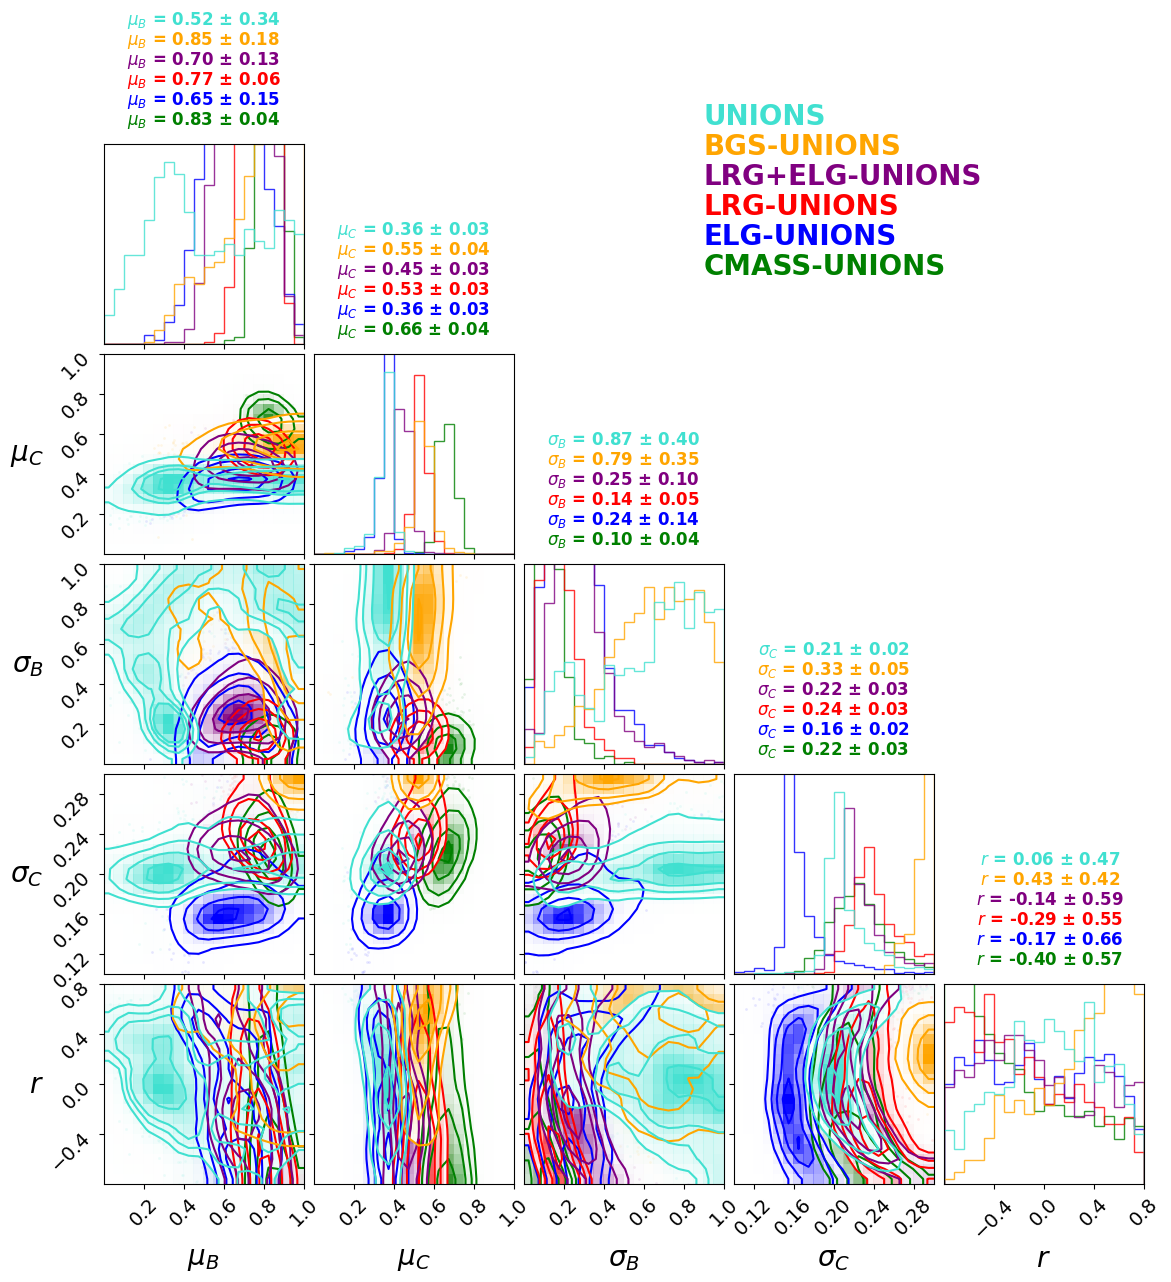

In [20]:
labels = [r"$\mu_B$", r"$\mu_C$", r"$\sigma_B$", r"$\sigma_C$", r"$r$"]
ranges = [[0, 1], [0, 1], [0, 1], [0.1, 0.3], [-0.8, 0.8]]

colors = ["green", "blue", "red", "purple", "orange", "turquoise"]
dataset_labels = ["CMASS-UNIONS", "ELG-UNIONS", "LRG-UNONS", "LRG+ELG-UNIONS", "BGS-UNIONS", "UNIONS"]
samples_list = [samples_cmass, samples_elg, samples_lrg, samples_lrg_elg, samples_bgs, samples_unions]


fig = corner.corner(
    samples_cmass,
    labels=labels, 
    range=ranges, 
    show_titles=False, 
    title_kwargs={"fontsize": 16},
    label_kwargs={"fontsize": 16}, 
    smooth=1.2,  
    plot_density=True,  
    plot_contours=True, 
    color=colors[0],
    hist_kwargs={"density": True, "alpha": 0.8}
)


corner.corner(
    samples_elg, 
    labels=labels, 
    range=ranges, 
    show_titles=False,  
    smooth=1.2,  
    plot_density=True,  
    plot_contours=True,  
    color=colors[1], 
    hist_kwargs={"density": True, "alpha": 0.8},
    fig=plt.gcf()  
)

corner.corner(
    samples_lrg, 
    labels=labels, 
    range=ranges, 
    show_titles=False,  
    smooth=1.2,  
    plot_density=True,  
    plot_contours=True,  
    color=colors[2], 
    hist_kwargs={"density": True, "alpha": 0.8},
    fig=plt.gcf()
)


corner.corner(
    samples_lrg_elg, 
    labels=labels, 
    range=ranges, 
    show_titles=False,  
    smooth=1.2,  
    plot_density=True,  
    plot_contours=True,  
    color=colors[3], 
    hist_kwargs={"density": True, "alpha": 0.8},
    fig=plt.gcf()
)


corner.corner(
    samples_bgs, 
    labels=labels, 
    range=ranges, 
    show_titles=False,  
    smooth=1.2,  
    plot_density=True,  
    plot_contours=True,  
    color=colors[4], 
    hist_kwargs={"density": True, "alpha": 0.8},
    fig=plt.gcf()
)


corner.corner(
    samples_unions, 
    labels=labels, 
    range=ranges, 
    show_titles=False,  
    smooth=1.2,  
    plot_density=True,  
    plot_contours=True,  
    color=colors[5], 
    hist_kwargs={"density": True, "alpha": 0.8},
    fig=plt.gcf()
)



ax = fig.axes[0]  
ax.annotate("CMASS-UNIONS", xy=(3, 0.35), xycoords="axes fraction", color=colors[0], fontsize=20, fontweight="bold")
ax.annotate("ELG-UNIONS", xy=(3, 0.5), xycoords="axes fraction", color=colors[1], fontsize=20, fontweight="bold")
ax.annotate("LRG-UNIONS", xy=(3, 0.65), xycoords="axes fraction", color=colors[2], fontsize=20, fontweight="bold")
ax.annotate("LRG+ELG-UNIONS", xy=(3, 0.8), xycoords="axes fraction", color=colors[3], fontsize=20, fontweight="bold")
ax.annotate("BGS-UNIONS", xy=(3, 0.95), xycoords="axes fraction", color=colors[4], fontsize=20, fontweight="bold")
ax.annotate("UNIONS", xy=(3, 1.1), xycoords="axes fraction", color=colors[5], fontsize=20, fontweight="bold")



axes = np.array(fig.axes).reshape((len(labels), len(labels)))

for i in range(len(labels)):
    ax = axes[i, i]
    y_max = ax.get_ylim()[1]
    y_offset = 0.1 * y_max

    for dataset, color, dataset_name in zip(samples_list, colors, dataset_labels):
        median = np.median(dataset[:, i])
        q16, q84 = np.percentile(dataset[:, i], [16, 84])
        err_minus, err_plus = median - q16, q84 - median

      
        x_pos = 0.05 
        if labels[i] == r"$\mu_B$":
            x_pos = 0.5 
        elif labels[i] == r"$\mu_C$":
            x_pos = 0.5  
        elif labels[i] == r"$\sigma_B$":
            x_pos = 0.5  
        elif labels[i] == r"$\sigma_C$":
            x_pos = 0.2  
        elif labels[i] == r"$r$":
            x_pos = 0.05  
        

        ax.text(
            x_pos, y_max + y_offset, 
            f"{labels[i]} = {median:.2f} ± {(err_plus + err_minus) / 2:.2f}",
            color=color, fontsize=12, fontweight="bold",
            ha="center", transform=ax.transData
        )
        y_offset += 0.1 * y_max



for ax in fig.axes:
    ax.tick_params(labelsize=14)


axes = np.array(fig.axes).reshape((len(labels), len(labels)))
for i in range(1, len(labels)):  
    ax = axes[i, 0]  
    label = ax.get_ylabel()
    ax.set_ylabel(label, rotation=0, fontsize=20, ha='right', va='center')


for i in range(len(labels)):
    ax = axes[-1, i]  
    label = ax.get_xlabel()
    ax.set_xlabel(label, fontsize=20)


fig.show()


plt.savefig('3D_constraints_all2.pdf',bbox_inches='tight')

### Saving the best fits...

- ...for the parameters of morphology $\theta$

In [21]:
# Best fit obtained after having performed the simulations

theta_estimated=np.mean(samples_cmass, axis=0)
mu_B_cmass, mu_C_cmass, sigma_B_cmass, sigma_C_cmass, r_cmass = theta_estimated[0], theta_estimated[1], theta_estimated[2], theta_estimated[3], theta_estimated[4]
print(f"Best fit CMASS-UNIONS{mu_B_cmass, mu_C_cmass, sigma_B_cmass, sigma_C_cmass, r_cmass}")

theta_estimated=np.mean(samples_elg, axis=0)
mu_B_elg, mu_C_elg, sigma_B_elg, sigma_C_elg, r_elg = theta_estimated[0], theta_estimated[1], theta_estimated[2], theta_estimated[3], theta_estimated[4]
print(f"Best fit ELG-UNIONS{mu_B_elg, mu_C_elg, sigma_B_elg, sigma_C_elg, r_elg}")

theta_estimated=np.mean(samples_lrg, axis=0)
mu_B_lrg, mu_C_lrg, sigma_B_lrg, sigma_C_lrg, r_lrg = theta_estimated[0], theta_estimated[1], theta_estimated[2], theta_estimated[3], theta_estimated[4]
print(f"Best fit LRG-UNIONS{mu_B_lrg, mu_C_lrg, sigma_B_lrg, sigma_C_lrg, r_lrg}")

theta_estimated=np.mean(samples_lrg_elg, axis=0)
mu_B_lrg_elg, mu_C_lrg_elg, sigma_B_lrg_elg, sigma_C_lrg_elg, r_lrg_elg = theta_estimated[0], theta_estimated[1], theta_estimated[2], theta_estimated[3], theta_estimated[4]
print(f"Best fit LRG+ELG-UNIONS{mu_B_lrg_elg, mu_C_lrg_elg, sigma_B_lrg_elg, sigma_C_lrg_elg, r_lrg_elg}")

theta_estimated=np.mean(samples_bgs, axis=0)
mu_B_bgs, mu_C_bgs, sigma_B_bgs, sigma_C_bgs, r_bgs = theta_estimated[0], theta_estimated[1], theta_estimated[2], theta_estimated[3], theta_estimated[4]
print(f"Best fit BGS-UNIONS{mu_B_bgs, mu_C_bgs, sigma_B_bgs, sigma_C_bgs, r_bgs}")

theta_estimated=np.mean(samples_unions, axis=0)
mu_B_unions, mu_C_unions, sigma_B_unions, sigma_C_unions, r_unions = theta_estimated[0], theta_estimated[1], theta_estimated[2], theta_estimated[3], theta_estimated[4]
print(f"Best fit UNIONS{mu_B_unions, mu_C_unions, sigma_B_unions, sigma_C_unions, r_unions}")

Best fit CMASS-UNIONS(0.83054656, 0.66346264, 0.111837, 0.23218563, -0.24891093)
Best fit ELG-UNIONS(0.65089196, 0.35363308, 0.2594765, 0.17168695, -0.20307617)
Best fit LRG-UNIONS(0.77310145, 0.5340505, 0.1589054, 0.25332835, -0.18373117)
Best fit LRG+ELG-UNIONS(0.70199955, 0.44885793, 0.27277002, 0.24270411, -0.08915795)
Best fit BGS-UNIONS(0.80224305, 0.5427392, 0.8208406, 0.34631243, 0.33706143)
Best fit UNIONS(0.55386823, 0.34976834, 0.8521269, 0.22170478, 0.037725393)


- ...for the associated $P(\vert e \vert)$

In [ ]:
e_counts_simulated_cmass = np.apply_along_axis(simulator, 1, samples_cmass)
hdu = fits.PrimaryHDU(e_counts_simulated_cmass) ; hdul = fits.HDUList([hdu])
hdul.writeto('e_counts_simulated_cmass.fits', overwrite=True)

e_counts_simulated_elg = np.apply_along_axis(simulator, 1, samples_elg)
hdu = fits.PrimaryHDU(e_counts_simulated_elg) ; hdul = fits.HDUList([hdu])
hdul.writeto('e_counts_simulated_elg.fits', overwrite=True)

e_counts_simulated_lrg = np.apply_along_axis(simulator, 1, samples_lrg)
hdu = fits.PrimaryHDU(e_counts_simulated_lrg) ; hdul = fits.HDUList([hdu])
hdul.writeto('e_counts_simulated_lrg.fits', overwrite=True)

e_counts_simulated_lrg_elg = np.apply_along_axis(simulator, 1, samples_lrg_elg)
hdu = fits.PrimaryHDU(e_counts_simulated_lrg_elg) ; hdul = fits.HDUList([hdu])
hdul.writeto('e_counts_simulated_lrg_elg.fits', overwrite=True)

e_counts_simulated_bgs = np.apply_along_axis(simulator, 1, samples_bgs)
hdu = fits.PrimaryHDU(e_counts_simulated_bgs) ; hdul = fits.HDUList([hdu])
hdul.writeto('e_counts_simulated_bgs.fits', overwrite=True)

e_counts_simulated_unions = np.apply_along_axis(simulator, 1, samples_unions)
hdu = fits.PrimaryHDU(e_counts_simulated_unions) ; hdul = fits.HDUList([hdu])
hdul.writeto('e_counts_simulated_unions.fits', overwrite=True)

In [22]:
hdul = fits.open('e_counts_simulated_cmass.fits')
e_counts_simulated_cmass = hdul[0].data
median_cmass = np.median(e_counts_simulated_cmass, axis=0)
quantiles_cmass = np.quantile(e_counts_simulated_cmass, [0.16,0.84], axis=0)

hdul = fits.open('e_counts_simulated_elg.fits')
e_counts_simulated_elg = hdul[0].data
median_elg = np.median(e_counts_simulated_elg, axis=0)
quantiles_elg = np.quantile(e_counts_simulated_elg, [0.16,0.84], axis=0)

hdul = fits.open('e_counts_simulated_lrg.fits')
e_counts_simulated_lrg = hdul[0].data
median_lrg = np.median(e_counts_simulated_lrg, axis=0)
quantiles_lrg = np.quantile(e_counts_simulated_lrg, [0.16,0.84], axis=0)

hdul = fits.open('e_counts_simulated_lrg_elg.fits') 
e_counts_simulated_lrg_elg = hdul[0].data
median_lrg_elg = np.median(e_counts_simulated_lrg_elg, axis=0)
quantiles_lrg_elg = np.quantile(e_counts_simulated_lrg_elg, [0.16,0.84], axis=0)

hdul = fits.open('e_counts_simulated_bgs.fits') 
e_counts_simulated_bgs = hdul[0].data
median_bgs = np.median(e_counts_simulated_bgs, axis=0)
quantiles_bgs = np.quantile(e_counts_simulated_bgs, [0.16,0.84], axis=0)

hdul = fits.open('e_counts_simulated_unions.fits') 
e_counts_simulated_unions = hdul[0].data
median_unions = np.median(e_counts_simulated_unions, axis=0)
quantiles_unions = np.quantile(e_counts_simulated_unions, [0.16,0.84], axis=0)

### Plotting the best fit and the data for P(e)

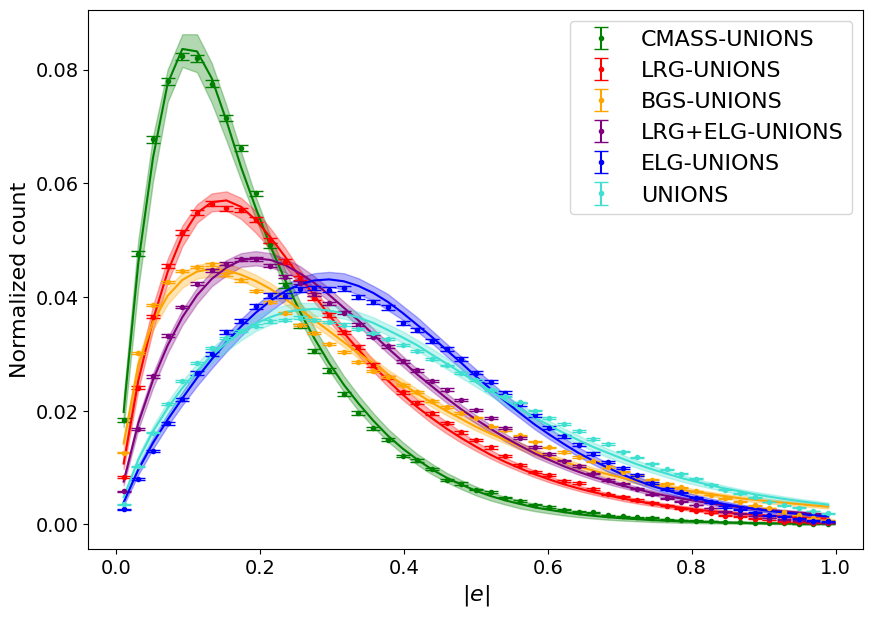

In [23]:
plt.figure( figsize = (10,7) )


plt.plot(e_cents,median_cmass,  linestyle='-', color='green')
plt.errorbar(e_cents, e_data_counts_cmass/nb_unions_cmass, yerr=np.sqrt(e_data_counts_cmass) / nb_unions_cmass, fmt='o',markersize=3, capsize=5,label='CMASS-UNIONS', color='green')
plt.fill_between(e_cents, quantiles_cmass[0], quantiles_cmass[1], color='green', alpha=0.3)


plt.plot(e_cents,median_lrg, linestyle='-', color='red')
plt.errorbar(e_cents, e_data_counts_lrg/nb_unions_lrg, yerr=np.sqrt(e_data_counts_lrg) / nb_unions_lrg, fmt='o',markersize=3, capsize=5, label='LRG-UNIONS', color='red')
plt.fill_between(e_cents, quantiles_lrg[0], quantiles_lrg[1], color='red', alpha=0.3)


plt.plot(e_cents,median_bgs, linestyle='-', color='orange')
plt.errorbar(e_cents, e_data_counts_bgs/nb_unions_bgs, yerr=np.sqrt(e_data_counts_bgs) / nb_unions_bgs, fmt='o',markersize=3, capsize=5, label='BGS-UNIONS', color='orange')
plt.fill_between(e_cents, quantiles_bgs[0], quantiles_bgs[1], color='orange', alpha=0.3)


plt.plot(e_cents,median_lrg_elg, linestyle='-', color='purple')
plt.errorbar(e_cents, e_data_counts_lrg_elg/nb_unions_lrg_elg, yerr=np.sqrt(e_data_counts_lrg_elg) / nb_unions_lrg_elg, fmt='o',markersize=3, capsize=5, label='LRG+ELG-UNIONS', color='purple')
plt.fill_between(e_cents, quantiles_lrg_elg[0], quantiles_lrg_elg[1], color='purple', alpha=0.3)


plt.plot(e_cents,median_elg, linestyle='-', color='blue')
plt.errorbar(e_cents, e_data_counts_elg/nb_unions_elg, yerr=np.sqrt(e_data_counts_elg) / nb_unions_elg, fmt='o',markersize=3, capsize=5, label='ELG-UNIONS', color='blue')
plt.fill_between(e_cents, quantiles_elg[0], quantiles_elg[1], color='blue', alpha=0.3)


plt.plot(e_cents,median_unions, linestyle='-', color='turquoise')
plt.errorbar(e_cents, e_data_counts_unions/nb_unions, yerr=np.sqrt(e_data_counts_unions) / nb_unions, fmt='o',markersize=3, capsize=5, label='UNIONS', color='turquoise')
plt.fill_between(e_cents, quantiles_unions[0], quantiles_unions[1], color='turquoise', alpha=0.3)




plt.legend(fontsize=16)
plt.xlabel(r"$\vert e \vert$", fontsize=16)
plt.ylabel("Normalized count", fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)


plt.savefig("P(e)_all.pdf", bbox_inches='tight')

### 3D population of galaxies constrained (from the 2D observed populations)

- Convention : A>B>C

/opt/homebrew/lib/python3.12/site-packages/seaborn/distributions.py:1176: UserWarning: linewidths is ignored by contourf
  cset = contour_func(
/opt/homebrew/lib/python3.12/site-packages/seaborn/distributions.py:1176: UserWarning: linewidths is ignored by contourf
  cset = contour_func(
/opt/homebrew/lib/python3.12/site-packages/seaborn/distributions.py:1176: UserWarning: linewidths is ignored by contourf
  cset = contour_func(


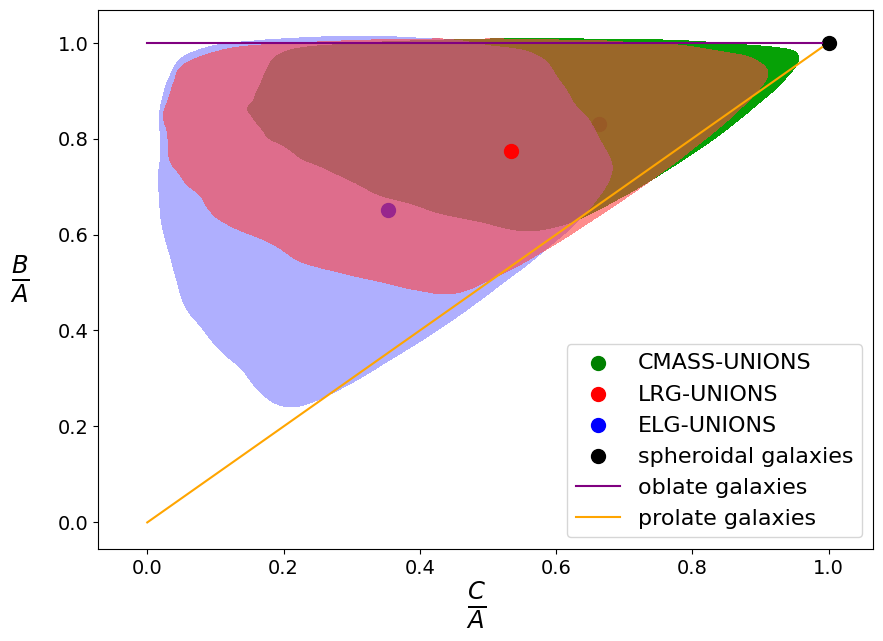

In [24]:
nb_galaxies=nb_unions_cmass; A=1
BC = np.random.multivariate_normal(mean=[mu_B_cmass,mu_C_cmass],cov=[[sigma_B_cmass**2,r_cmass*sigma_B_cmass*sigma_C_cmass],[r_cmass*sigma_B_cmass*sigma_C_cmass,sigma_C_cmass**2]],size=nb_galaxies)
mask = (BC[:, 0] / A <= 1) & (BC[:, 1] / A <= 1) & (BC[:, 0] >= BC[:, 1]) & (BC[:, 0] > 0) & (BC[:, 1] > 0)
BC_cmass = BC[mask]


nb_galaxies=nb_unions_elg; A=1
BC = np.random.multivariate_normal(mean=[mu_B_elg,mu_C_elg],cov=[[sigma_B_elg**2,r_elg*sigma_B_elg*sigma_C_elg],[r_elg*sigma_B_elg*sigma_C_elg,sigma_C_elg**2]],size=nb_galaxies)
mask = (BC[:, 0] / A <= 1) & (BC[:, 1] / A <= 1) & (BC[:, 0] >= BC[:, 1]) & (BC[:, 0] > 0) & (BC[:, 1] > 0)
BC_elg = BC[mask]


nb_galaxies=nb_unions_lrg; A=1
BC = np.random.multivariate_normal(mean=[mu_B_lrg,mu_C_lrg],cov=[[sigma_B_lrg**2,r_lrg*sigma_B_lrg*sigma_C_lrg],[r_lrg*sigma_B_lrg*sigma_C_lrg,sigma_C_lrg**2]],size=nb_galaxies)
mask = (BC[:, 0] / A <= 1) & (BC[:, 1] / A <= 1) & (BC[:, 0] >= BC[:, 1]) & (BC[:, 0] > 0) & (BC[:, 1] > 0)
BC_lrg = BC[mask]


nb_galaxies=nb_unions_lrg_elg; A=1
BC = np.random.multivariate_normal(mean=[mu_B_lrg_elg,mu_C_lrg_elg],cov=[[sigma_B_lrg_elg**2,r_lrg_elg*sigma_B_lrg_elg*sigma_C_lrg_elg],[r_lrg_elg*sigma_B_lrg_elg*sigma_C_lrg_elg,sigma_C_lrg_elg**2]],size=nb_galaxies)
mask = (BC[:, 0] / A <= 1) & (BC[:, 1] / A <= 1) & (BC[:, 0] >= BC[:, 1]) & (BC[:, 0] > 0) & (BC[:, 1] > 0)
BC_lrg_elg = BC[mask]


nb_galaxies=nb_unions_bgs; A=1
BC = np.random.multivariate_normal(mean=[mu_B_bgs,mu_C_bgs],cov=[[sigma_B_bgs**2,r_bgs*sigma_B_bgs*sigma_C_bgs],[r_bgs*sigma_B_bgs*sigma_C_bgs,sigma_C_bgs**2]],size=nb_galaxies)
mask = (BC[:, 0] / A <= 1) & (BC[:, 1] / A <= 1) & (BC[:, 0] >= BC[:, 1]) & (BC[:, 0] > 0) & (BC[:, 1] > 0)
BC_bgs = BC[mask]


nb_galaxies=nb_unions; A=1
BC = np.random.multivariate_normal(mean=[mu_B_unions,mu_C_unions],cov=[[sigma_B_unions**2,r_unions*sigma_B_unions*sigma_C_unions],[r_unions*sigma_B_unions*sigma_C_unions,sigma_C_unions**2]],size=nb_galaxies)
mask = (BC[:, 0] / A <= 1) & (BC[:, 1] / A <= 1) & (BC[:, 0] >= BC[:, 1]) & (BC[:, 0] > 0) & (BC[:, 1] > 0)
BC_unions = BC[mask]




plt.figure( figsize = (10,7) )


sns.kdeplot(x=BC_cmass[:,1]/A, y=BC_cmass[:,0]/A, levels=2, color='green', fill=True, alpha=1,linewidths=0)
plt.scatter([mu_C_cmass], [mu_B_cmass], color='green', s=100,  label='CMASS-UNIONS')

sns.kdeplot(x=BC_elg[:,1]/A, y=BC_elg[:,0]/A, levels=2, color='blue', fill=True, alpha=0.6, linewidths=0)
plt.scatter([mu_C_elg], [mu_B_elg], color='blue', s=100,  label='ELG-UNIONS')

sns.kdeplot(x=BC_lrg[:,1]/A, y=BC_lrg[:,0]/A, levels=2, color='red', fill=True, alpha=0.6, linewidths=0)
plt.scatter([mu_C_lrg], [mu_B_lrg], color='red', s=100, label='LRG-UNIONS')


plt.scatter([1], [1], color='black', label='spheroidal galaxies', s=100)


x=np.linspace(0,0.99,30) ; y=x
plt.plot(x, y,color='orange',label='prolate galaxies')
plt.plot(x, np.ones(len(x)),color='purple',label='oblate galaxies')

plt.xlabel(r"$\frac{C}{A}$", fontsize=25, rotation=0, labelpad=20, ha='right', va='center')
plt.ylabel(r"$\frac{B}{A}$", fontsize=25, rotation=0, labelpad=20, ha='right', va='center')

handles, labels = plt.gca().get_legend_handles_labels() ; order = [0, 2, 1, 3, 5, 4]
plt.legend([handles[i] for i in order], [labels[i] for i in order], fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)

plt.show()

/opt/homebrew/lib/python3.12/site-packages/seaborn/distributions.py:1176: UserWarning: linewidths is ignored by contourf
  cset = contour_func(


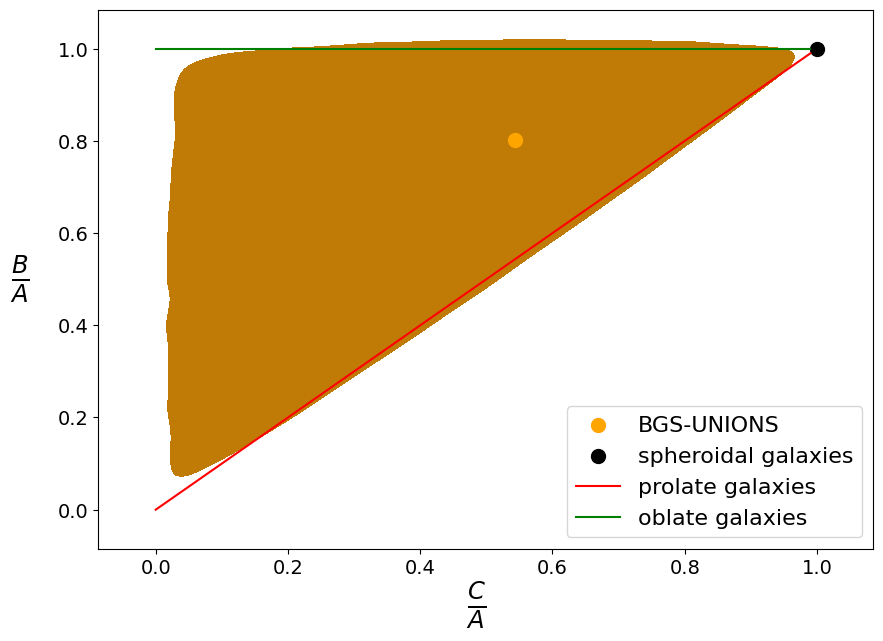

In [27]:
plt.figure( figsize = (10,7) )



sns.kdeplot(x=BC_bgs[:,1]/A, y=BC_bgs[:,0]/A, levels=2, color='orange', fill=True, alpha=1,linewidths=0)
plt.scatter([mu_C_bgs], [mu_B_bgs], color='orange', s=100,  label='BGS-UNIONS')

plt.scatter([1], [1], color='black', label='spheroidal galaxies', s=100)


x=np.linspace(0,0.99,30) ; y=x
plt.plot(x, y,color='red',label='prolate galaxies')
plt.plot(x, np.ones(len(x)),color='green',label='oblate galaxies')

plt.xlabel(r"$\frac{C}{A}$", fontsize=25, rotation=0, labelpad=20, ha='right', va='center')
plt.ylabel(r"$\frac{B}{A}$", fontsize=25, rotation=0, labelpad=20, ha='right', va='center')

plt.legend(fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)

plt.show()

/opt/homebrew/lib/python3.12/site-packages/seaborn/distributions.py:1176: UserWarning: linewidths is ignored by contourf
  cset = contour_func(


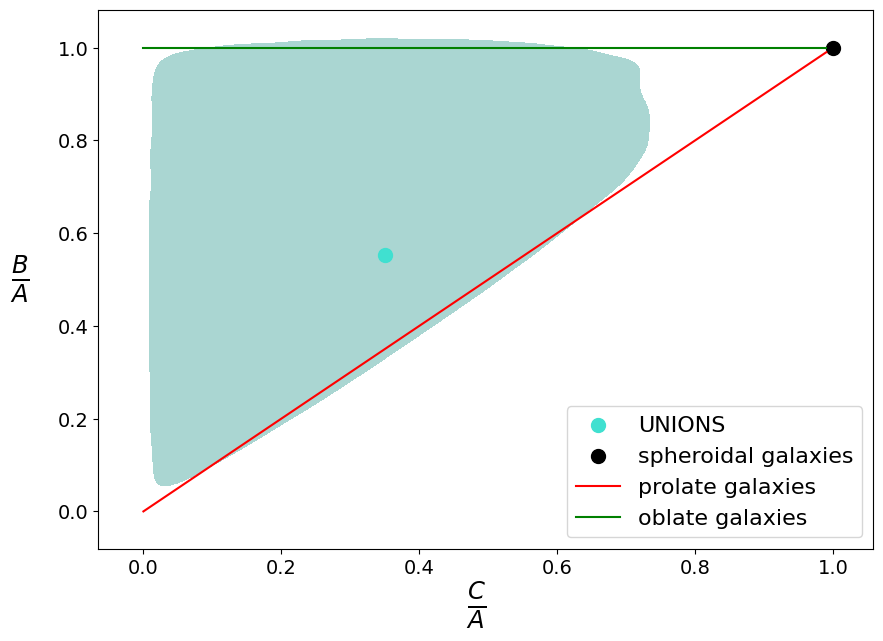

In [28]:
plt.figure( figsize = (10,7) )


sns.kdeplot(x=BC_unions[:,1]/A, y=BC_unions[:,0]/A, levels=2, color='turquoise', fill=True, alpha=0.4, linewidths=0)
plt.scatter([mu_C_unions], [mu_B_unions], color='turquoise', s=100,  label='UNIONS')

plt.scatter([1], [1], color='black', label='spheroidal galaxies', s=100)


x=np.linspace(0,0.99,30) ; y=x
plt.plot(x, y,color='red',label='prolate galaxies')
plt.plot(x, np.ones(len(x)),color='green',label='oblate galaxies')

plt.xlabel(r"$\frac{C}{A}$", fontsize=25, rotation=0, labelpad=20, ha='right', va='center')
plt.ylabel(r"$\frac{B}{A}$", fontsize=25, rotation=0, labelpad=20, ha='right', va='center')


plt.legend(fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)

plt.show()

/opt/homebrew/lib/python3.12/site-packages/seaborn/distributions.py:1176: UserWarning: linewidths is ignored by contourf
  cset = contour_func(


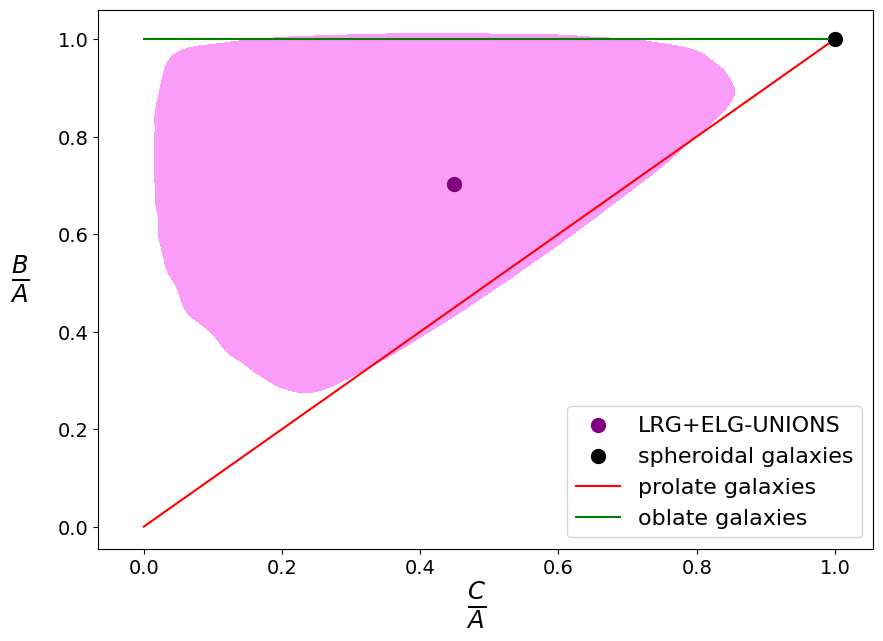

In [29]:
plt.figure( figsize = (10,7) )


sns.kdeplot(x=BC_lrg_elg[:,1]/A, y=BC_lrg_elg[:,0]/A, levels=2, color='purple', fill=True, alpha=0.4, linewidths=0)
plt.scatter([mu_C_lrg_elg], [mu_B_lrg_elg], color='purple', s=100, label='LRG+ELG-UNIONS')

plt.scatter([1], [1], color='black', label='spheroidal galaxies', s=100)


x=np.linspace(0,0.99,30) ; y=x
plt.plot(x, y,color='red',label='prolate galaxies')
plt.plot(x, np.ones(len(x)),color='green',label='oblate galaxies')

plt.xlabel(r"$\frac{C}{A}$", fontsize=25, rotation=0, labelpad=20, ha='right', va='center')
plt.ylabel(r"$\frac{B}{A}$", fontsize=25, rotation=0, labelpad=20, ha='right', va='center')


plt.legend(fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)

plt.show()